In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

f = mtick.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))

from os import listdir, mkdir
from os.path import isdir
rcParams = {'font.size': 20 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal', 'xtick.labelsize':20,
            'ytick.labelsize':20,'axes.spines.right' : False,
            'axes.spines.top' : False}

def Fit_Regression(df, xcol = 'Num_genes', ycol = 'Total_seqs_multi', logx = True, logy = True):
    x = np.array(df[xcol].tolist())
    y = np.array(df[ycol].tolist())
    y[y==0] = 1
    if logx:
        x = np.log10(x)
    if logy:
        y = np.log10(y)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    M = LinearRegression()
    M.fit(x, y)
    m = M.coef_[0][0]
    c = M.intercept_[0]
    y_ind = np.where(y != 0)[0]
    e = np.mean(np.abs(y[y_ind] - M.predict(x[y_ind]))/y[y_ind])*100
    r2 = r2_score(y, M.predict(x))
    return m, e, c, r2

def Plot_Box_Plots(boxes, positions, color, ax, widths = 0.45, lw = 3.5, 
                   scatter = True, deviation = 0.045, s = 70, alpha = 0.1):
    flierprops = dict(marker='x', markersize=0.5, linestyle='none')
    whiskerprops = dict(color='black',linewidth=1.5)
    capprops = dict(color='black', linewidth=0.5)
    medianprops = dict(linewidth=1.5, linestyle='-', color='black')
    box = ax.boxplot(boxes, positions=positions, whis = [2.5,97.5], widths = [widths]*len(positions),
                     showfliers = False, boxprops = dict(linestyle='-', linewidth=lw, color=color), 
                     flierprops = flierprops, whiskerprops = whiskerprops, capprops = capprops, 
                     medianprops = medianprops)
    
    if(scatter):
        for i in range(0, len(positions)):
            y = boxes[i]
            x = np.random.normal(positions[i], deviation, size=len(y))
            ax.scatter(x,y,color = color,alpha = alpha, marker = 'o', s = s)
            
def get_array_sum(v):
    s = 0
    for k in v:
        s+=int(k)
    return s

def Return_Num_Species(grp):
    species_lists = grp['species_list'].tolist()
    agg_list = []
    for s in species_lists:
        agg_list += s
    return len(set(agg_list))

def agg_lists(grp):
    species_lists = grp['species_list'].tolist()
    agg_list = []
    for s in species_lists:
        agg_list += s
    return set(agg_list)

def Summarize(df):
    df_msc = df[df['Num_Species'] > 1].groupby('Num_genes').agg({'Cluster_number':'nunique', 
                                                                 'Cluster_Size':'sum'})
    df_msc['Num_species'] = df[df['Num_Species'] > 1].groupby('Num_genes').apply(Return_Num_Species)
    df_msc = df_msc.rename(columns = {'Cluster_Size':'Total_seqs_multi', 
                                      'Cluster_number':'Num_multispecies',
                                      'Num_species':'Species_in_multispecies'})

    df_fpl_grp = df.groupby('Num_genes').agg({'Cluster_number':'nunique', 'Cluster_Size':'sum'})
    df_fpl_grp['Num_species'] = df_fpl.groupby('Num_genes').apply(Return_Num_Species)
    df_fpl_grp = df_fpl_grp.rename(columns = {'Cluster_Size':'Total_seqs', 'Cluster_number':'Num_clusters'})
    df_fpl_grp = df_fpl_grp.join(df_msc)
    df_fpl_grp['Frac_MSC'] = df_fpl_grp['Species_in_multispecies']/df_fpl_grp['Num_species']*100.0
    df_fpl_grp = df_fpl_grp.reset_index()
    m, err, c, r2  = Fit_Regression(df_fpl_grp)
    df_fpl_grp['m'] = m
    df_fpl_grp['Error'] = err
    return df_fpl_grp

In [2]:
outdir = '/Users/harihara/Research-Activities/Plots/Species_Boundary/'
if not isdir(outdir):
    mkdir(outdir)

In [4]:
data_path = '/Users/harihara/Research-Activities/Data/Species_Boundary/All_Bacteria/Try_3/'
num_marker_genes = 120
thresh = 50
similarity = ['95','97','99','100']
df_MSC = pd.DataFrame()
df_fit = pd.DataFrame()


In [5]:
for sim in similarity:
    Multispecies, Allspecies = {}, {}
    for g in listdir(data_path+sim+"/"):
        if g.startswith("."): continue
        gene = g.replace("_results.txt.gz","").replace("_results.txt","")\
                .replace(".0.99","").replace(".0.97","").replace(".0.95","").replace(".1.0","")
        df_fpl = pd.read_csv(data_path+sim+"/"+g, sep = "\t")    
        df_fpl['Spcies_counts_list'] = df_fpl['Species_counts'].str.split(",")
        df_fpl['species_list'] = df_fpl['Species'].str.split(",")
        df_fpl['Num_Species'] = df_fpl['species_list'].apply(len)
        df_fpl['Cluster_Size'] = df_fpl['Spcies_counts_list'].apply(get_array_sum)
        df_fpl_summary = Summarize(df_fpl)
        df_fpl_summary['Gene'] = gene
        df_fpl_summary['Similarity'] = sim
        df_fit = pd.concat([df_fit, df_fpl_summary])
        
        d_multi_species = df_fpl[df_fpl['Num_Species'] > 1].groupby(['Num_genes']).apply(agg_lists).to_dict()
        d_all_species = df_fpl.groupby(['Num_genes']).apply(agg_lists).to_dict()
        
        for d in d_multi_species:
            for s in d_multi_species[d]:
                try: Multispecies[d][s] += 1
                except KeyError:
                    try: Multispecies[d][s] = 1
                    except KeyError: Multispecies[d] = {s:1}
            try: Allspecies[d] = Allspecies[d].union(d_all_species[d])
            except KeyError: Allspecies[d] = d_all_species[d]
    op = []
    for d in Multispecies.keys():
        num_species_gt_thresh, num_species = 0, len(Allspecies[d])
        for s in Multispecies[d].keys():
            if Multispecies[d][s] > thresh: 
                num_species_gt_thresh += 1
        op.append({'Num_Genes':int(d), 'Frac_MSC':num_species_gt_thresh*100.0/num_species})
    df = pd.DataFrame(op)
    df['Similarity'] = sim
    df_MSC = pd.concat([df_MSC, df], axis = 0)
    
    print(sim)

95
97
99
100


In [6]:
silva_dir = '/Users/harihara/Research-Activities/Data/Species_Boundary/All_Bacteria/Try_2/SILVA_Database/'
for fi in listdir(silva_dir):
    if fi.startswith('.'): continue
        
    df = pd.read_csv(silva_dir+fi, sep = "\t")
    df['Frac_MSC'] = df['Species_in_multispecies']/df['Num_species']*100.0
    m,e,c,r2 = Fit_Regression(df)
    df['Gene'] = '16S rRNA'
    df['m'] = m
    df['Error'] = e
    
    if '0.99' in fi: s = '99'
    if '0.97' in fi: s = '97'
    if '0.95' in fi: s = '95'
    if '1.0' in fi: s = '100'
    df['Similarity'] = s
    df_fit = df_fit.append(df, ignore_index = True)

In [7]:
taxa_counts_dir = '/Users/harihara/Research-Activities/Data/Species_Boundary/All_Bacteria/Try_2/genus_counts/'
df_taxa_counts = pd.DataFrame()
for f in listdir(taxa_counts_dir):
    df = pd.read_csv(taxa_counts_dir+f, sep = "\t")
    df['Similarity'] = f.replace("taxa_counts_","").replace(".txt","")
    m, e, c, r2 = Fit_Regression(df, 'Num_Species', 'Num_multispecies_clusters', False, False)
    df['m'] = round(m, 2)
    df['c'] = round(c, 2)
    df['r2'] = round(r2, 2)
    df_taxa_counts = df_taxa_counts.append(df, ignore_index = True)

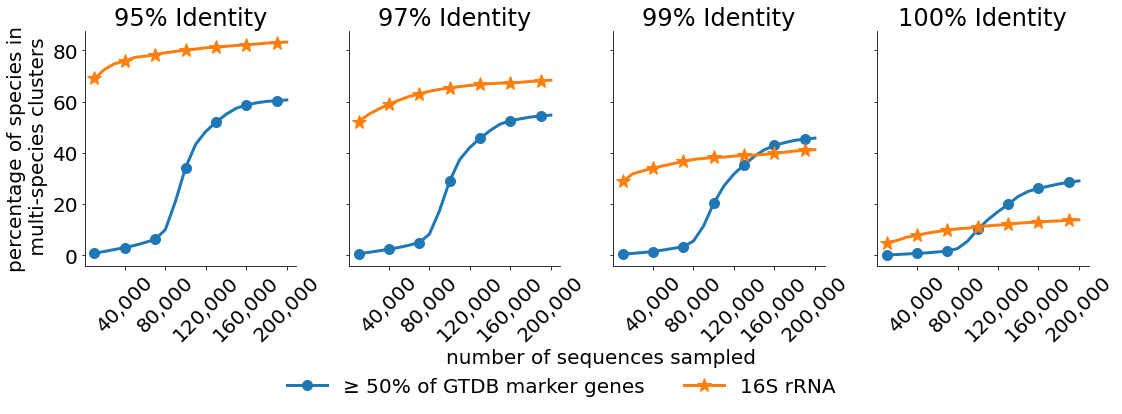

In [29]:
plt.rcParams.update(rcParams)

fig, ax = plt.subplots(1,4,figsize = (16, 6), sharey = True)
for i in range(0, len(similarity)):
    df_MSC[(df_MSC['Similarity'] == similarity[i]) & 
           (df_MSC['Num_Genes'] <= 200000)].plot('Num_Genes','Frac_MSC', ax = ax[i], legend = False, 
                                                 label = '≥ 50% of GTDB marker genes',
                                                 linewidth = 3, marker = 'o', markevery = 3, ms = 10)
    df_fit[(df_fit['Similarity'] == similarity[i]) &
           (df_fit['Num_genes'] <= 200000) & 
           (df_fit['Gene'] == '16S rRNA')].plot('Num_genes','Frac_MSC', ax = ax[i], label = '16S rRNA', 
                                                       legend = False, linewidth = 3, marker = '*', 
                                                       markevery = 3, ms = 15)
    ax[i].set_xlabel('')
    ax[i].set_title(similarity[i]+"% Identity")
    ax[i].set_xticks([40000, 80000, 120000, 160000, 200000])
    ax[i].set_xticklabels(['40,000', '80,000', '120,000', '160,000', '200,000'], rotation = 45)
ax[0].set_ylabel('percentage of species in\n multi-species clusters')
handles, labels = ax[0].get_legend_handles_labels()
fig.text(0.4, 0.125,'number of sequences sampled')
fig.legend(handles, labels, loc='lower center', ncol = 2, frameon = False, fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(bottom = 0.35)

fig.savefig(outdir+'Figure-3.pdf',bbox_inches="tight")
fig.savefig(outdir+'Figure-3.png',bbox_inches="tight")
fig.savefig(outdir+'Figure-3.tiff',bbox_inches="tight")


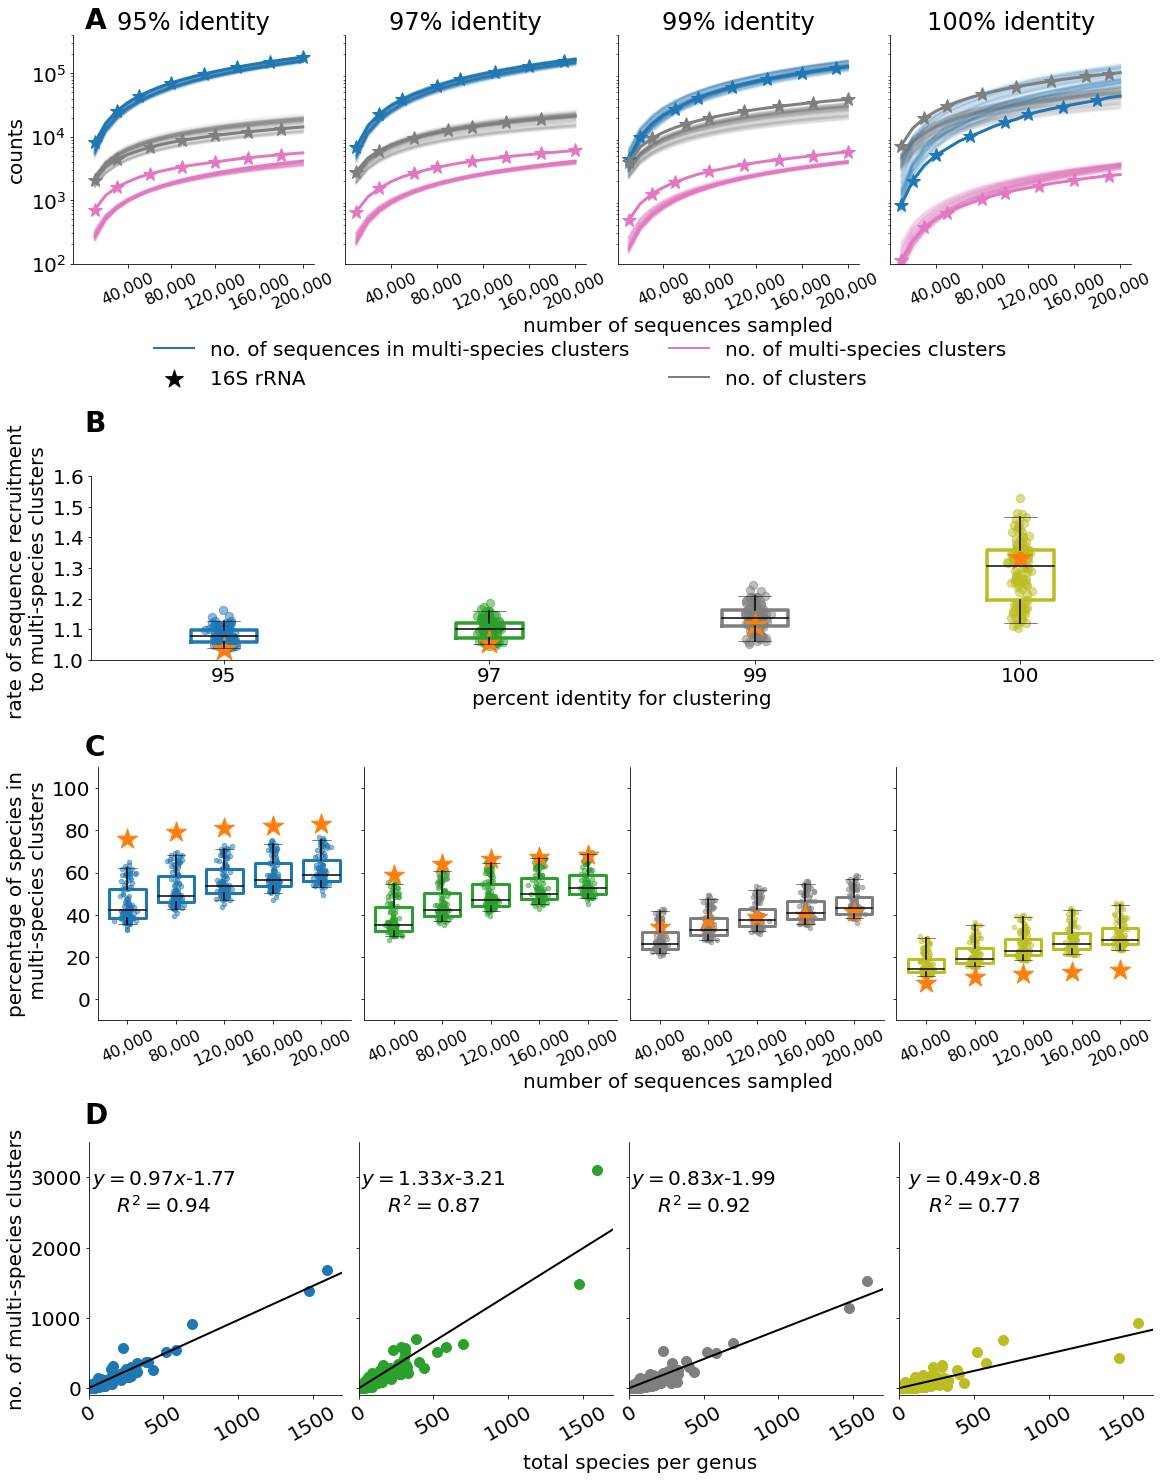

In [27]:
plt.rcParams.update(rcParams)

fig = plt.figure(constrained_layout = True,figsize = (16,20))
gs0 = fig.add_gridspec(8, 1,  height_ratios=[5,1.5,0.75,4,0.75,5,1,5])

gs1 = gs0[0].subgridspec(1, 4)
ax1, ax2, ax3, ax4 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1]), fig.add_subplot(gs1[2]), fig.add_subplot(gs1[3])
ax5  = fig.add_subplot(gs0[1])

ax_t = fig.add_subplot(gs0[2])
#ax_t.axhline(0.5, color = 'black')
ax_t.axis('off')

gst_ = gs0[3].subgridspec(1,1)
ax6 = fig.add_subplot(gst_[0])
    
ax_t = fig.add_subplot(gs0[4])
#ax_t.axhline(0.5, color = 'black')
ax_t.axis('off')

gs2 = gs0[5].subgridspec(1, 4)
ax7 = fig.add_subplot(gs2[0])
ax8 = fig.add_subplot(gs2[1])
ax9 = fig.add_subplot(gs2[2])
ax10 = fig.add_subplot(gs2[3])

ax_t = fig.add_subplot(gs0[6])
#ax_t.axhline(0.5, color = 'black')
ax_t.axis('off')

gs3 = gs0[7].subgridspec(1, 4)
ax11 = fig.add_subplot(gs3[0])
ax12 = fig.add_subplot(gs3[1])
ax13 = fig.add_subplot(gs3[2])
ax14 = fig.add_subplot(gs3[3])

colors = ['C0','C2','C7','C8']
similarities = ['95','97','99','100']
for i in range(len(similarities)) :
    df = df_fit[df_fit['Similarity'] == similarities[i]]
    Plot_Box_Plots([df.loc[(df['Gene'] != '16S rRNA')]['m'].unique()], [i+1], colors[i], ax6, widths = 0.25, 
                   deviation = 0.02, alpha = 0.5)
    ax6.scatter(i+1, df.loc[(df['Gene'] == '16S rRNA')]['m'].unique(), marker = '*', s = 650, color = 'C1')

ax6.set_ylabel('rate of sequence recruitment \nto multi-species clusters')
#ax6.grid()
ax6.set_xticks([1,2,3,4])
ax6.set_xticklabels(similarities)
ax6.set_xlabel('percent identity for clustering')
ax6.set_yticks([1,1.1,1.2,1.3,1.4,1.5,1.6])
ax6.set_ylim([1, 1.6])
#ax6.spines['top'].set_visible(False) 
#ax6.spines['right'].set_visible(False)
genes = df_fit.Gene.unique()
genes.sort()
genes = genes[::-1]

ax = [ax1,ax2,ax3,ax4]
for i in range(0, len(similarities)):
    for gene in genes:
        try:
            df = df_fit[(df_fit['Similarity'] == similarities[i])&(df_fit['Gene'] == gene)]
            df = df[(df['Num_genes'] <= 200000) & (df['Num_genes'] >= 10000)]
            df = df.sort_values(by = 'Num_genes')
            
            if gene != '16S rRNA':
                ax[i].plot(df['Num_genes'].tolist(),df['Total_seqs_multi'].tolist(), color = 'C0', 
                           alpha = 0.05, linewidth = 2)
                #ax[i].plot(df['Num_genes'].tolist(),df['Num_species'].tolist(),  color = 'C1',
                #           linewidth = 2, alpha = 0.05)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_clusters'].tolist(), color = 'C7',
                           linewidth = 2, alpha = 0.05)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_multispecies'].tolist(), color = 'C6',
                           linewidth = 2, alpha = 0.05)
            
            if gene == '16S rRNA':
                ax[i].plot(df['Num_genes'].tolist(),df['Total_seqs_multi'].tolist(), linewidth = 3, 
                           marker = '*', markevery = 0.1, color = 'C0', ms = 15)
                #ax[i].plot(df['Num_genes'].tolist(),df['Num_species'].tolist(), markevery = 0.1,
                #           color = 'C1', linewidth = 3, marker = '*', ms = 15)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_clusters'].tolist(), color = 'C7',
                           linewidth = 3, markevery = 0.1, ms = 15, marker = '*')
                ax[i].plot(df['Num_genes'].tolist(),df['Num_multispecies'].tolist(), color = 'C6',
                           linewidth = 3, markevery = 0.1, ms = 15, marker = '*')
                
        except KeyError:
            continue
        ax[i].semilogy()
        ax[i].set_xticks([40000, 80000, 120000, 160000, 200000])
        ax[i].set_xticklabels(['40,000', '80,000', '120,000', '160,000', '200,000'], rotation = 25, 
                              fontsize = 16)
        ax[i].set_title(similarities[i]+'% identity')
        ax[i].set_ylim([100, 400000])
        if i > 0:
            ax[i].set_yticks([])
ax[0].set_ylabel('counts')
ax[0].set_ylabel('counts')
ax[0].plot([-1, 1], color = 'C0', linewidth =2, label = 'no. of sequences in multi-species clusters')
ax[0].scatter(-1, -1, marker = '*', s = 350, color = 'black', label = '16S rRNA')
ax[0].plot([-1, 1], color = 'C6', linewidth =2, label = 'no. of multi-species clusters')
ax[0].plot([-1, 1], color = 'C7', linewidth =2, label = 'no. of clusters')

fig.text(0.45,0.775,'number of sequences sampled')

handles, labels = ax[0].get_legend_handles_labels()
ax5.legend(handles, labels, loc='center', ncol = 2, frameon = False, fontsize = 20)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.axis('off')

database_sizes =  [40000, 80000, 120000, 160000, 200000]
ax = [ax7, ax8, ax9, ax10]
for i in range(0, len(similarities)):
    box = []
    scatter = []
    for d in database_sizes:
        df = df_fit[(df_fit['Num_genes'] == d)&(df_fit['Similarity'] == similarities[i])]
        box.append(df.loc[(df['Gene']!='16S rRNA')]['Frac_MSC'].tolist())
        scatter += df.loc[(df['Gene']=='16S rRNA')]['Frac_MSC'].tolist()
    Plot_Box_Plots(box, database_sizes, colors[i], ax[i], widths = 30000, scatter = True, s = 20, 
                   deviation=2500, lw = 3, alpha = 0.5)
    ax[i].scatter(database_sizes, scatter, marker = '*', s = 450, color = 'C1')
    ax[i].set_xticks(database_sizes)
    ax[i].set_xticklabels(database_sizes, rotation = 45)
    #ax[i].set_xlim(ax1.get_xlim())
    ax[i].set_ylim([-10, 110])
    if i != 0:
        ax[i].set_yticklabels([])
    ax[i].set_xticks([40000, 80000, 120000, 160000, 200000])
    ax[i].set_xticklabels(['40,000', '80,000', '120,000', '160,000', '200,000'], rotation = 25, fontsize = 16)
ax[0].set_ylabel('percentage of species in\n multi-species clusters')
fig.text(0.45,0.25,'number of sequences sampled')

ax = [ax11,ax12,ax13,ax14]
for i in range(0, len(similarities)):
    df = df_taxa_counts[df_taxa_counts['Similarity'] == similarities[i]]
    m = df.iloc[0]['m']
    c = df.iloc[0]['c']
    r2 = df.iloc[0]['r2']
    x = np.array([0,1700])
    y = m*x + c
    ax[i].scatter(df['Num_Species'], df['Num_multispecies_clusters'], s = 100, color = colors[i])
    ax[i].plot(x, y, color = 'black', linewidth = 2)
    ax[i].set_xticks([0, 500, 1000, 1500])
    ax[i].set_xticklabels([0, 500, 1000, 1500], rotation = 30)
    ax[i].set_ylim([-100, 3500])
    ax[i].set_xlim([0, 1700])
    
    if i != 0: ax[i].set_yticklabels([])
    else: ax[i].set_yticks(range(0, 3500, 1000))
    ax[i].text(500, 2500, r'$y=$'+str(m)+r'$x$'+str(c)+'\n'+r'$R^2=$'+str(r2), ha='center', fontsize = 20)
ax[0].set_ylabel('no. of multi-species clusters')
fig.text(0.45, -0.015, 'total species per genus')

fig.text(0.07,0.985,'A', size = 28, weight = 'bold')
fig.text(0.07,0.705,'B', size = 28, weight = 'bold')
fig.text(0.07,0.48,'C', size = 28, weight = 'bold')
fig.text(0.07,0.225,'D', size = 28, weight = 'bold')

fig.savefig(outdir+'Figure-1.pdf',bbox_inches="tight")
fig.savefig(outdir+'Figure-1.png',bbox_inches="tight")
fig.savefig(outdir+'Figure-1.tiff',bbox_inches="tight")


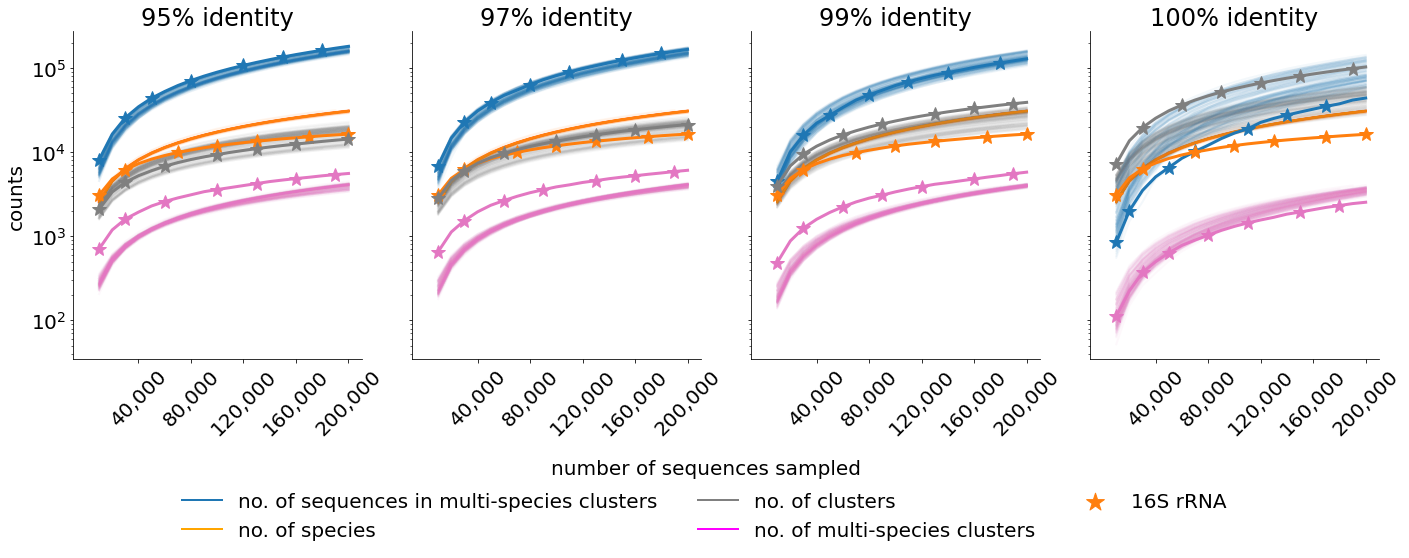

In [19]:
fig,ax = plt.subplots(1, 4, figsize = (20,8), sharey = True, sharex = True)
genes = df_fit.Gene.unique()
genes.sort()
genes = genes[::-1]

for i in range(0, len(similarities)):
    for gene in genes:
        try:
            df = df_fit[(df_fit['Similarity'] == similarities[i])&(df_fit['Gene'] == gene)]
            df = df[(df['Num_genes'] <= 200000) & (df['Num_genes'] >= 10000)]
            df = df.sort_values(by = 'Num_genes')
            
            if gene != '16S rRNA':
                ax[i].plot(df['Num_genes'].tolist(),df['Total_seqs_multi'].tolist(), color = 'C0', alpha = 0.05, 
                           linewidth = 2)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_species'].tolist(),  color = 'C1',
                           linewidth = 2, alpha = 0.05)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_clusters'].tolist(), color = 'C7',
                           linewidth = 2, alpha = 0.05)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_multispecies'].tolist(), color = 'C6',
                           linewidth = 2, alpha = 0.05)
            
            if gene == '16S rRNA':
                ax[i].plot(df['Num_genes'].tolist(),df['Total_seqs_multi'].tolist(), linewidth = 3, 
                           marker = '*', markevery = 0.1, color = 'C0', ms = 15)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_species'].tolist(), markevery = 0.1,
                           color = 'C1', linewidth = 3, marker = '*', ms = 15)
                ax[i].plot(df['Num_genes'].tolist(),df['Num_clusters'].tolist(), color = 'C7',
                           linewidth = 3, markevery = 0.1, ms = 15, marker = '*')
                ax[i].plot(df['Num_genes'].tolist(),df['Num_multispecies'].tolist(), color = 'C6',
                           linewidth = 3, markevery = 0.1, ms = 15, marker = '*')
                
        except KeyError:
            continue
        ax[i].semilogy()
        ax[i].set_xticks([40000, 80000, 120000, 160000, 200000])
        ax[i].set_xticklabels(['40,000', '80,000', '120,000', '160,000', '200,000'], rotation = 45)
        ax[i].set_title(similarities[i]+'% identity')
ax[0].set_ylabel('counts')
ax[0].plot([-1, 1], color = 'C0', linewidth =2, label = 'no. of sequences in multi-species clusters')
ax[0].plot([-1, 1], color = 'orange', linewidth =2, label='no. of species')
ax[0].plot([-1, 1], color = 'grey', linewidth =2, label = 'no. of clusters')
ax[0].plot([-1, 1], color = 'magenta', linewidth =2, label = 'no. of multi-species clusters')
ax[0].scatter(-1, -1, marker = '*', s = 350, color = 'C1', label = '16S rRNA')

fig.text(0.5, 0.15, 'number of sequences sampled', ha='center')

fig.tight_layout()
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol = 3, frameon = False, fontsize = 20)
fig.subplots_adjust(bottom = 0.35)

fig.savefig(outdir+'Supplementary-Material-Fig-1.pdf')
fig.savefig(outdir+'Supplementary-Material-Fig-1.png')
fig.savefig(outdir+'Supplementary-Material-Fig-1.tiff')